## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
pip install swifter

In [29]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.corpus import stopwords

import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import swifter

from sklearn.model_selection import GridSearchCV


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Opening JSON file 
f = open("/content/drive/MyDrive/Automatic Ticket Classification Assignment/complaints.json") # Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

#### Inspecting the dataframe to understand the given data

In [ ]:
df.shape

(78313, 22)

In [ ]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


- The df_info function has been defined for the purpose of data exploration. It contains NaN count and unique value count.

In [ ]:
def df_info(df=df):
    df_data = pd.DataFrame(df.isnull().sum()).reset_index()
    df_data = pd.merge(df_data,pd.DataFrame(df.apply(lambda x:x.nunique(dropna=False))).reset_index(),on='index',how='left')
    df_data.columns = ['Column Name','NaN Count','Unique Value Count']
    return df_data

In [ ]:
df_info()

,Column Name,NaN Count,Unique Value Count
0,_index,0,1
1,_type,0,1
2,_id,0,78313
3,_score,0,1
4,_source.tags,67413,4
5,_source.zip_code,6757,9443
6,_source.complaint_id,0,78313
7,_source.issue,0,154
8,_source.date_received,0,3444
9,_source.state,1991,63


In [ ]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new column names
cols_list = list(df.columns)
cols_list = [i[1:].replace('source.','').strip() for i in cols_list]
df.columns = cols_list

In [7]:
df.rename(columns={'complaint_what_happened':'complaint'},inplace=True)

In [8]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = np.where(df['complaint']=='',np.nan,df['complaint'])

In [9]:
#Remove all rows where complaints column is nan
df = df[df['complaint'].notnull()].reset_index(drop=True)

- The check_word_frequency function has been defined to check average word frequency.

In [10]:
def check_word_frequency(text):
    return len(str(text).split(' '))

In [11]:
df['word_freq'] = df['complaint'].apply(check_word_frequency)
df['word_freq'].mean()

253.99283409263478

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


### Data Preparation

- Creating dictionary with contractions and their respective expansions to use in the expandContractions function.
- The expandContractions function has been defined to expand contractions for ease of processing/removal of stop words.

In [12]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
df['complaint']=df['complaint'].astype(str)

- The clean (preprocess) function has been defined to clean the complaint column so that the cleaned text data can be fed into the NMF model. 
- The clean function:
1.   Converts text to lower case
2.   Removes text within square brackets, words with numbers, newline (line break), punctuations, stop words.
3. Expands contractions.



In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean(complaint):
    complaint=complaint.lower()
    complaint=re.sub("[\[].*?[\]]","",complaint) #Removing text in square brackets
    complaint=re.sub("\w*\d\w*","",complaint) #Removing words with numbers
    complaint=re.sub(r"\n"," ",complaint) #Removing newline
    complaint=expandContractions(complaint)  #Expanding contractions
    complaint=re.sub(r"[^\w\s]+","",complaint) #Removing all punctuations
    words_list=word_tokenize(complaint)
    words_list = [i for i in words_list if i not in stopwords.words("english")]  #Removing stop words
    complaint=' '.join(words_list)
    clean_complaint=re.sub(' +',' ',complaint)
    return clean_complaint

*Using swifter to speed up .apply() as the number of rows > 20000.*

In [ ]:
df['complaint_clean']=df['complaint'].swifter.apply(clean)
df['complaint']=df['complaint'].apply(lambda x:re.sub(' +',' ',x))  #removing extra spaces

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [16]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

The function token_process() has been defined to lemmatise the text.

In [17]:
#Write your function to Lemmatize the texts
lem = WordNetLemmatizer()

def token_process(text):
    tokens = word_tokenize(text)
    #tokens = list(filter(lambda x:x not in tokens))
    processed_token = []
    for w,pos in pos_tag(tokens):
        try:
            processed_token.append(lem.lemmatize(w,pos=pos[0].lower()))
        except:
            processed_token.append(lem.lemmatize(w))
    processed_text = ' '.join(processed_token)
    return processed_text

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint','complaint_clean']]
df_clean['complaint_lemmatized'] = df['complaint_clean'].swifter.apply(token_process)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- The function pos_tagger() has been defined to get the POS tag for each word in a given text.
- The function remove_nn() has been defined to remove all tags other than 'NN'.

In [ ]:
#Write your function to extract the POS tags 

def pos_tagger(text):
    text_list=word_tokenize(text)
    text_pos=pos_tag(text_list)
    return text_pos

def remove_nn(s):
    sr=[i for i in s if i[1]=='NN']
    return ' '.join([i[0] for i in sr])

In [ ]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean['POS']= df_clean['complaint_lemmatized'].swifter.apply(pos_tagger)
df_clean["complaint_POS_removed"] = df_clean['POS'].apply(remove_nn)
df_clean=df_clean.drop('POS',axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
#Removing empty rows (could result in NaN values for some rows after applying remove_nn())
df_clean=df_clean[df_clean['complaint_POS_removed'].notnull()].reset_index(drop=True)

In [ ]:
df_clean['complaint_POS_removed']=df_clean['complaint_POS_removed'].str.lower()
df_clean=df_clean[df_clean['complaint_POS_removed'].str.islower()].reset_index(drop=True)

In [ ]:
df_clean

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,xxxx card tell agent date information order up...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...
...,...,...,...,...
21065,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...
21066,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas xxxx credit card provider claim purc...
21067,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...
21068,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs I chase credit cards chase...,flawless credit yr I chase credit card chase f...,flawless credit yr credit card chase freedom x...


<Figure size 1080x720 with 0 Axes>

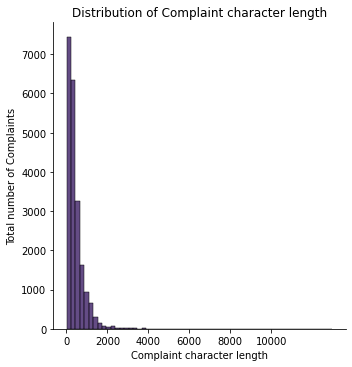

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
comp_len=df_clean['complaint_POS_removed'].str.len()

fig = plt.figure(figsize=(15,10))
sns.displot(comp_len, kind='hist', bins=60,color='#30105C')
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.yticks(np.arange(0, 8000, 1000))
plt.xticks(np.arange(0, 12000, 2000))
plt.show()

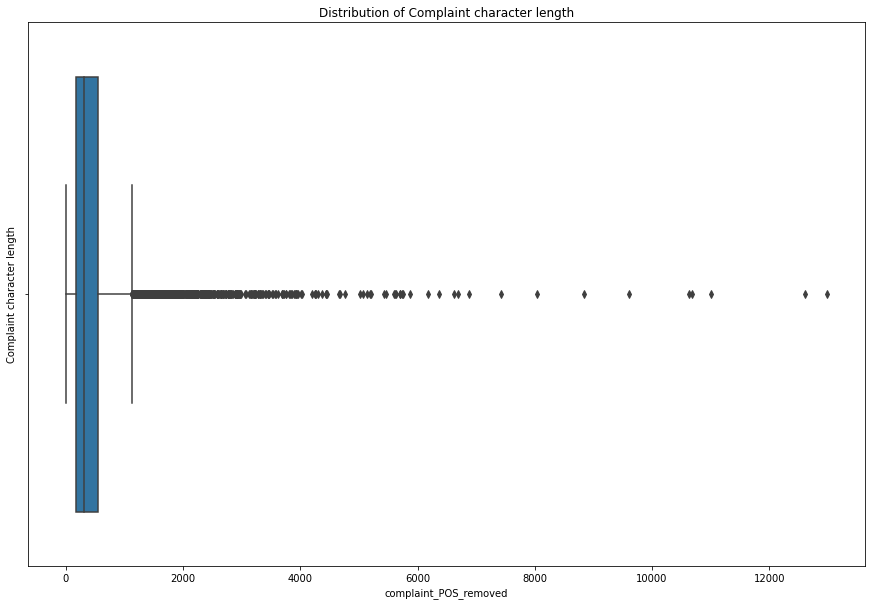

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(comp_len)
plt.ylabel("Complaint character length")
plt.title("Distribution of Complaint character length")
plt.show()

The character length for most complaints is between 0 and 2000. There are very few beyond 2000.

#### Find the top 40 words by frequency among all the articles after processing the text.

Before getting top 40, removing xxxx as it is unecessary information and occurs very frequently, skewing the top40 data.

In [ ]:
df_clean['complaint_POS_removed']=df_clean['complaint_POS_removed'].apply(lambda y:re.sub("x(x)+","" ,y))
df_clean['complaint_POS_removed']=df_clean['complaint_POS_removed'].apply(lambda y:re.sub(' +',' ',y))  #removing extra spaces

In [ ]:
flat_complaints = [j for i in df_clean['complaint_POS_removed'].str.split() for j in i]
top40 = pd.DataFrame(nltk.FreqDist(flat_complaints).most_common(40),columns=['Word', 'Freq'])

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

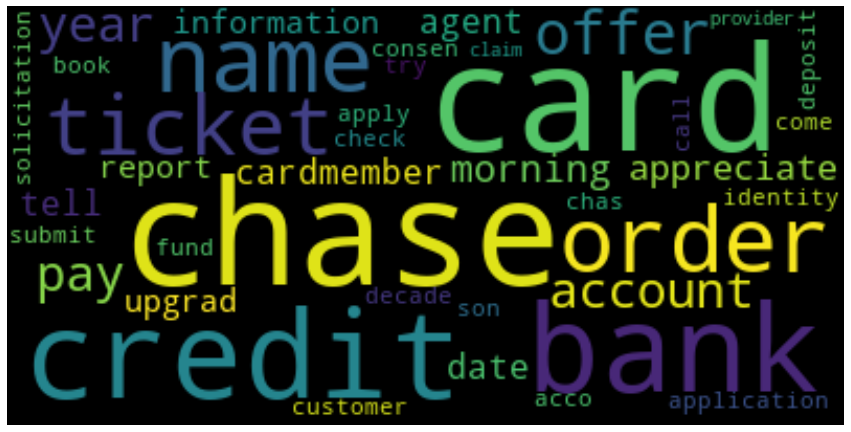

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=70, max_words=40, 
                      background_color="black", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The wordcloud shows that the most common words in the complaint column are:
1. chase (company name)
2. card
3. credit
4. bank
5. order
6. account
7. cardmember
8. ticket
9. deposit
10. check



In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-pron-', '')


In [ ]:
df_clean

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,card tell agent date information order upgrad...,card tell agent date information order upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,try book ticket come offer apply ticket card i...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...
...,...,...,...,...,...
21065,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...
21066,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase ...,call chas credit card provider claim purchase ...
21067,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...
21068,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs I chase credit cards chase...,flawless credit yr I chase credit card chase f...,flawless credit yr credit card chase freedom p...,flawless credit yr credit card chase freedom p...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

- The function ngram() has been defined to get the unigrams, bigrams and trigrams of the text. 
- The function takes in the text and n (gram) as input.

In [ ]:
def ngram(s,n):
    s=s.split(" ")
    l=[s[i:i+n] for i in range(0,len(s))]
    l=[i for i in l if len(i)==n]
    l=pd.DataFrame([' '.join(i) for i in l],columns=[str(n)+'-gram'])
    l=pd.value_counts(l[str(n)+'-gram']).reset_index()
    return l

In [ ]:
all_complaints=' '.join(df_clean['Complaint_clean'])

In [ ]:
unigram=ngram(all_complaints,1)

In [ ]:
bigram=ngram(all_complaints,2)

In [ ]:
trigram=ngram(all_complaints,3)

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_uni=unigram[:30]

In [ ]:
top30_uni

,index,1-gram
0,chase,54226
1,account,43661
2,credit,34086
3,bank,28651
4,card,26598
5,payment,21176
6,call,18239
7,charge,17083
8,time,16072
9,day,13198


The gram_plot() function has been defined to get the bar plot of top 30 n-grams.

In [ ]:
def gram_plot(df,n):
    plt.figure(figsize=[18,8])
    sns.barplot(x=df['index'], y=df[str(n)+'-gram'])
    plt.xticks(rotation=45)
    plt.xlabel(str(n)+'-gram')
    plt.ylabel("Count")
    plt.title("Count of top 30 "+str(n)+'-grams')
    plt.show()

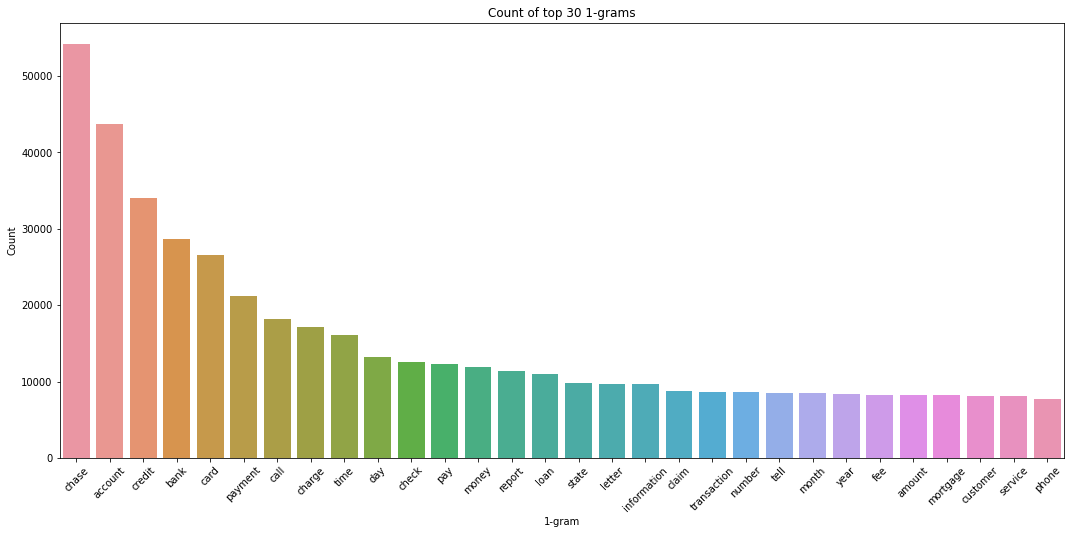

In [ ]:
gram_plot(top30_uni,1)

In [ ]:
#Print the top 10 words in the unigram frequency
top30_uni.loc[:10,'index']

0       chase
1     account
2      credit
3        bank
4        card
5     payment
6        call
7      charge
8        time
9         day
10      check
Name: index, dtype: object

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_bi=bigram[:30]

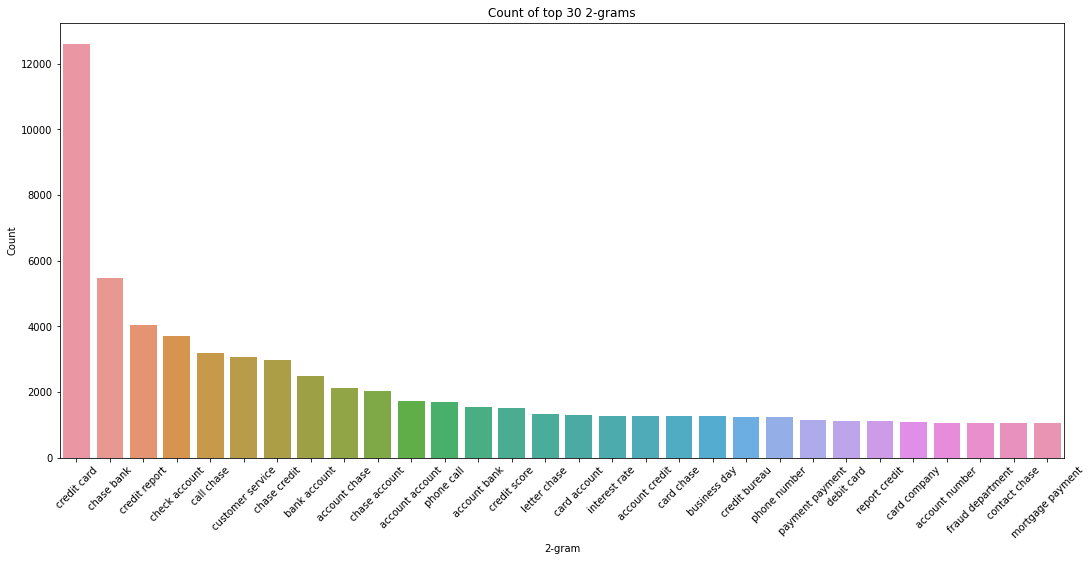

In [ ]:
gram_plot(top30_bi,2)

In [ ]:
#Print the top 10 words in the bigram frequency
top30_bi.loc[:10,'index']

0          credit card
1           chase bank
2        credit report
3        check account
4           call chase
5     customer service
6         chase credit
7         bank account
8        account chase
9        chase account
10     account account
Name: index, dtype: object

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top30_tri=trigram[:30]

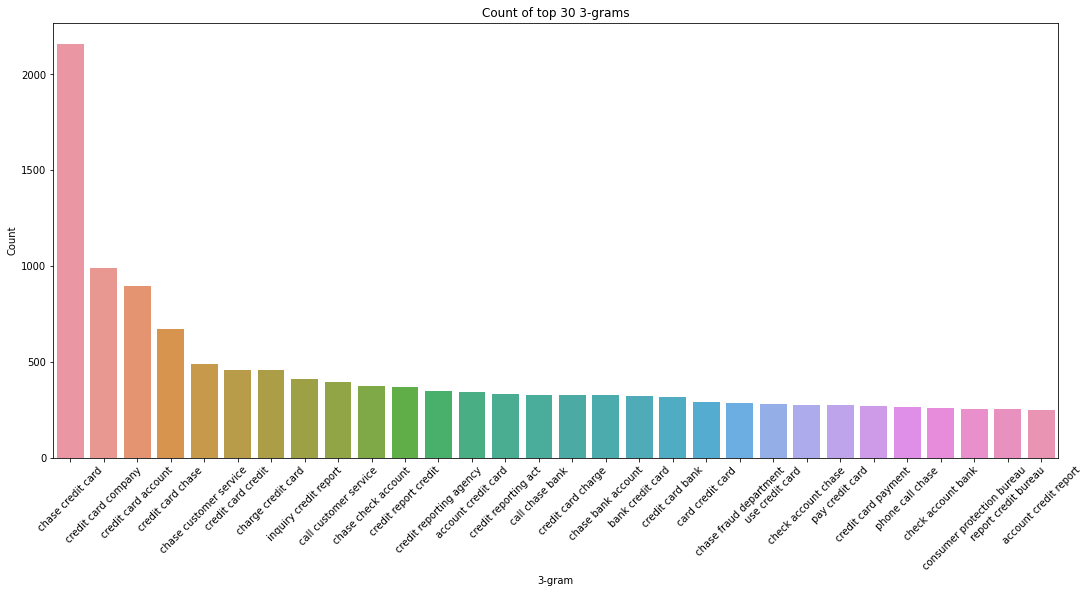

In [ ]:
gram_plot(top30_tri,3)

In [ ]:
#Print the top 10 words in the trigram frequency
top30_tri.loc[:10,'index']

0          chase credit card
1        credit card company
2        credit card account
3          credit card chase
4     chase customer service
5         credit card credit
6         charge credit card
7      inquiry credit report
8      call customer service
9        chase check account
10      credit report credit
Name: index, dtype: object

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
#All masked texts has been removed
df_clean

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,card tell agent date information order upgrad...,card tell agent date information order upgrad...
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,card report application submit identity consen...
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,try book ticket come offer apply ticket card i...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...
...,...,...,...,...,...
21065,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...
21066,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase ...,call chas credit card provider claim purchase ...
21067,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...
21068,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs I chase credit cards chase...,flawless credit yr I chase credit card chase f...,flawless credit yr credit card chase freedom p...,flawless credit yr credit card chase freedom p...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [18]:
#Write your code here to initialise the TfidfVectorizer 
tfidf_vectorizer = TfidfVectorizer(min_df=2,max_df=0.95,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [24]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [20]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [21]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [25]:
nmf_model.fit(tfidf)
len(tfidf_vectorizer.get_feature_names())

7293

In [18]:
tfidf_fn = tfidf_vectorizer.get_feature_names()

- The top_words() function has been defined to get the top words for each topic.
- The unique_words() function has been defined to remove duplicate words.
- The topic_table() finction has been ddefined to create a table with the top words for each topic and the topic created by the NMF model.

In [19]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1] 

def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [20]:
from nltk.tokenize import RegexpTokenizer

In [21]:
def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

In [22]:
docweights = nmf_model.transform(tfidf_vectorizer.transform(df_clean['Complaint_clean'])) #Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

n_top_words = 15

topic_df = topic_table(
    nmf_model,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

In [23]:
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topics
0,account,bank,check,money,chase,deposit,fund,day,branch,transaction,number,transfer,tell,claim,business,account bank check money chase deposit fund da...
1,credit,card,report,inquiry,chase,account,company,score,information,bureau,debt,limit,letter,application,year,credit card report inquiry chase account compa...
2,loan,mortgage,chase,home,modification,property,year,letter,rate,time,house,sale,foreclosure,document,bank,loan mortgage chase home modification property...
3,charge,card,fee,chase,dispute,transaction,purchase,merchant,claim,fraud,refund,service,pay,statement,balance,charge card fee chase dispute transaction purc...
4,payment,pay,balance,month,statement,fee,day,auto,time,date,chase,credit,account,year,mortgage,payment pay balance month statement fee day au...


In [ ]:
#This matrix has wt of each row (complaint) belonging to each cluster. Therefore, to each complaint the cluster with max wt should be assigned
docweights.shape

(21070, 5)

In [24]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

,topic_num,topics
0,0,account bank check money chase deposit fund da...
1,1,credit card report inquiry chase account compa...
2,2,loan mortgage chase home modification property...
3,3,charge card fee chase dispute transaction purc...
4,4,payment pay balance month statement fee day au...


Assigning the relevant topic labels to each topic num by going through the topics.

In [25]:
topic_df.loc[topic_df['topic_num']==0,'Topic Label'] = 'Bank Account services'
topic_df.loc[topic_df['topic_num']==1,'Topic Label'] = 'Credit card or prepaid card'
topic_df.loc[topic_df['topic_num']==2,'Topic Label'] = 'Mortgage/Loan'
topic_df.loc[topic_df['topic_num']==3,'Topic Label'] = 'Theft/Dispute Reporting'
topic_df.loc[topic_df['topic_num']==4,'Topic Label'] = 'Other'

In [26]:
topic_df

,topic_num,topics,Topic Label
0,0,account bank check money chase deposit fund da...,Bank Account services
1,1,credit card report inquiry chase account compa...,Credit card or prepaid card
2,2,loan mortgage chase home modification property...,Mortgage/Loan
3,3,charge card fee chase dispute transaction purc...,Theft/Dispute Reporting
4,4,payment pay balance month statement fee day au...,Other


Creating topic_num:topic_name dictionary

In [27]:
topic_names=dict()
for i in range(0,len(topic_df)):
    topic_names[topic_df.loc[i,'topic_num']] = topic_df.loc[i,'Topic Label']

In [28]:
topic_names

{0: 'Bank Account services',
 1: 'Credit card or prepaid card',
 2: 'Mortgage/Loan',
 3: 'Theft/Dispute Reporting',
 4: 'Other'}

In [29]:
# Transforming the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(df_clean['Complaint_clean'])
X_new = nmf_model.transform(tfidf_new)

# Getting the top predicted topic
predicted_topics = []
predicted_topic_labels = []

for each in X_new:
    predicted_topics.append(np.argsort(each)[::-1][0])
    predicted_topic_labels.append(topic_names[np.argsort(each)[::-1][0]])
df_clean['pred_topic'] = predicted_topics
df_clean['pred_topic_label'] = predicted_topic_labels

In [30]:
df_clean

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,pred_topic,pred_topic_label
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,card report application submit identity consen...,1,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,try book ticket come offer apply ticket card i...,1,Credit card or prepaid card
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0,Bank Account services
...,...,...,...,...,...,...,...
21065,After being a Chase Card customer for well ove...,chase card customer well decade offered multip...,chase card customer well decade offer multiple...,chase card customer decade offer solicitation ...,chase card customer decade offer solicitation ...,1,Credit card or prepaid card
21066,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,call chas credit card provider claim purchase ...,call chas credit card provider claim purchase ...,3,Theft/Dispute Reporting
21067,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx pay understand great risk provid...,pay risk consumer chase bank chase year trust ...,pay risk consumer chase bank chase year trust ...,3,Theft/Dispute Reporting
21068,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs I chase credit cards chase...,flawless credit yr I chase credit card chase f...,flawless credit yr credit card chase freedom p...,flawless credit yr credit card chase freedom p...,4,Other


In [31]:
df_clean.rename(columns={'pred_topic':'Topic'},inplace=True)

In [32]:
#Print the first 5 Complaint for each of the Topics
df_clean1=df_clean.groupby('Topic').head(5)
df_clean1.sort_values('Topic')

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic,pred_topic_label
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0,Bank Account services
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0,Bank Account services
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restricted account debi...,notice jp morgan chase restrict account debit ...,jp restrict account debit card tuesday thursda...,jp restrict account debit card tuesday thursda...,0,Bank Account services
10,mishandling of this account by Chase auto and ...,mishandling account chase auto xxxx,mishandle account chase auto xxxx,account auto,account auto,0,Bank Account services
12,I opened an account with chase bank on XXXX an...,opened account chase bank xxxx used code xxxx ...,open account chase bank xxxx use code xxxx bon...,account bank use code bonus call term tell eve...,account bank use code bonus call term tell eve...,0,Bank Account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1,Credit card or prepaid card
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,card report application submit identity consen...,1,Credit card or prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,try book ticket come offer apply ticket card i...,1,Credit card or prepaid card
5,Can you please remove inquiry,please remove inquiry,please remove inquiry,inquiry,inquiry,1,Credit card or prepaid card
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card incorrectly report data cred...,chase credit card credit report company issue,chase credit card credit report company issue,1,Credit card or prepaid card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [33]:
#df_clean1.rename(columns={'Topic':'Topic_Num','pred_topic_label':'Topic'},inplace=True)
df_clean.rename(columns={'Topic':'Topic_Num','pred_topic_label':'Topic'},inplace=True)


In [34]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account services':0,'Credit card or prepaid card':1,'Mortgage/Loan':2,'Theft/Dispute Reporting':3,'Other':4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


In [35]:
df_clean.head()

,complaint,complaint_clean,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic_Num,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,good morning name xxxx xxxx appreciate could h...,morning name appreciate chase bank cardmember ...,morning name appreciate chase bank cardmember ...,0,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent upgrad...,upgraded xxxx xxxx card xxxx tell agent upgrad...,card tell agent date information order upgrad...,card tell agent date information order upgrad...,1,1
2,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx however fraudulent ap...,chase card report xxxx however fraudulent appl...,card report application submit identity consen...,card report application submit identity consen...,1,1
3,"On XX/XX/2018, while trying to book a XXXX XXX...",xxxx trying book xxxx xxxx ticket came across ...,xxxx try book xxxx xxxx ticket come across off...,try book ticket come offer apply ticket card i...,try book ticket come offer apply ticket card i...,1,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son give check deposit chase account fun...,son check deposit chase account fund bank acco...,son check deposit chase account fund bank acco...,0,0


In [36]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint','Topic']]

In [37]:
training_data

,complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XXX...",1
4,my grand son give me check for {$1600.00} i de...,0
...,...,...
21065,After being a Chase Card customer for well ove...,1
21066,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
21067,I am not familiar with XXXX pay and did not un...,3
21068,I have had flawless credit for 30 yrs. I've ha...,4


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

In [39]:
X=training_data['complaint'].values
y=training_data['Topic'].values

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=40)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
#Write your code to get the Vector count
vectorizer = CountVectorizer()
  
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [43]:
X_train.shape , X_test.shape

((16856, 26933), (4214, 26933))

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer

The TfidfTransformer transforms the word vector created by the count vectorizer to a tfidf vector. 

**Refer:** https://stackoverflow.com/questions/58143171/converting-count-vectorizer-to-tf-idf

In [45]:
#Write your code here to transform the word vector to tf-idf
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train).toarray()
X_test = transformer.transform(X_test).toarray()

In [46]:
X_train.shape , X_test.shape

((16856, 26933), (4214, 26933))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

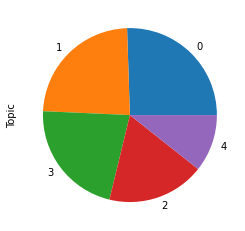

In [44]:
training_data['Topic'].value_counts().plot(kind='pie')
plt.show()

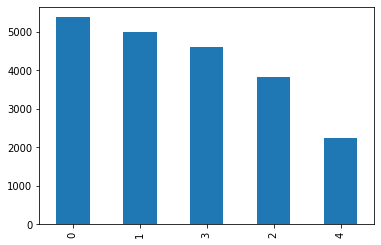

In [45]:
training_data['Topic'].value_counts().plot(kind='bar')
plt.show()

There is barely any class imbalance in the data.

**Naive Bayes Classifier**

In [48]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

y_pred_nb = nb.predict(X_test)

In [49]:
clf_nb_report = classification_report(y_test,y_pred_nb)

**Random Forest Classifier**

In [50]:
rf = RandomForestClassifier(random_state=40,n_estimators=40)
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_test)

In [51]:
clf_rf_report = classification_report(y_test,y_pred_rf)

**Decision Tree Classifier**

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
dt=DecisionTreeClassifier(random_state=40)
dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)

In [54]:
clf_dt_report = classification_report(y_test,y_pred_dt)

**Logistic Regression**

In [55]:
from sklearn.linear_model import LogisticRegression

In [57]:
lr=LogisticRegression(random_state=40)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [58]:
clf_lr_report = classification_report(y_test,y_pred_lr)

### Model Evaluation

In [59]:
print('CLASSIFICATION REPORT FOR EACH MODEL')
print('Naive Bayes Classifier: ')
print(F'ACC : {accuracy_score(y_test,y_pred_nb)}')
print(clf_nb_report)
print('---------------------------------------------------------')
print('Random Forest Classifier')
print(F'ACC : {accuracy_score(y_test,y_pred_rf)}')
print(clf_rf_report)
print('---------------------------------------------------------')
print('Decision Tree Classifier')
print(F'ACC : {accuracy_score(y_test,y_pred_dt)}')
print(clf_rf_report)
print('---------------------------------------------------------')
print('Logistic Regression')
print(F'ACC : {accuracy_score(y_test,y_pred_lr)}')
print(clf_lr_report)

CLASSIFICATION REPORT FOR EACH MODEL
Naive Bayes Classifier: 
ACC : 0.7280493592785952
              precision    recall  f1-score   support

           0       0.67      0.92      0.77      1129
           1       0.71      0.75      0.73       987
           2       0.86      0.75      0.80       751
           3       0.75      0.77      0.76       920
           4       1.00      0.02      0.04       427

    accuracy                           0.73      4214
   macro avg       0.80      0.64      0.62      4214
weighted avg       0.76      0.73      0.69      4214

---------------------------------------------------------
Random Forest Classifier
ACC : 0.8054105363075462
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1129
           1       0.77      0.83      0.80       987
           2       0.89      0.82      0.85       751
           3       0.79      0.82      0.80       920
           4       0.93      0.45      0.60  

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [76]:
def plot_overall_metric(m):
    d=pd.DataFrame(columns=['Model',m])
    d['Model']=['Naive Bayes','Random Forest','Decision Tree','Logistic Regression']
    if m=='Accuracy':
        d[m]=[accuracy_score(y_test,i) for i in [y_pred_nb,y_pred_rf,y_pred_dt,y_pred_lr]]
    elif m=='Precision':
        d[m]=[precision_score(y_test,i,average='weighted') for i in [y_pred_nb,y_pred_rf,y_pred_dt,y_pred_lr]]
    elif m=='Recall':
        d[m]=[recall_score(y_test,i,average='weighted') for i in [y_pred_nb,y_pred_rf,y_pred_dt,y_pred_lr]]
    else:
        d[m]=[f1_score(y_test,i,average='weighted') for i in [y_pred_nb,y_pred_rf,y_pred_dt,y_pred_lr]]
    plt.figure(figsize=[10,5])
    sns.lineplot(data=m,x=d["Model"],y=d[m])
    plt.title(m)
    plt.show()

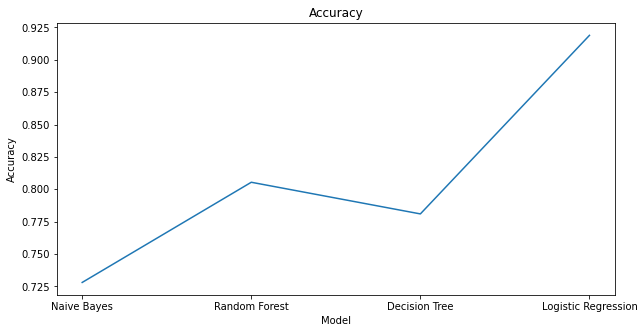

In [74]:
plot_overall_metric('Accuracy')

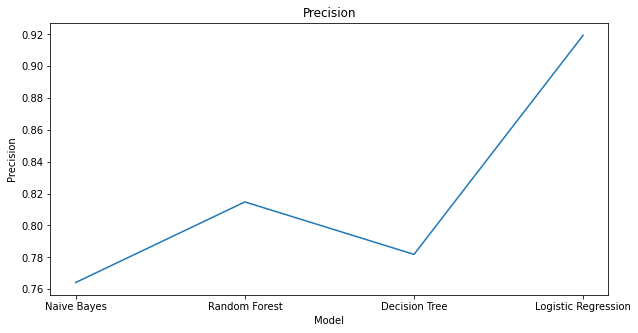

In [77]:
plot_overall_metric('Precision')

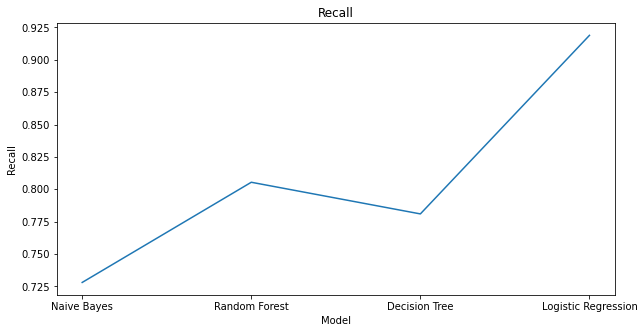

In [78]:
plot_overall_metric('Recall')

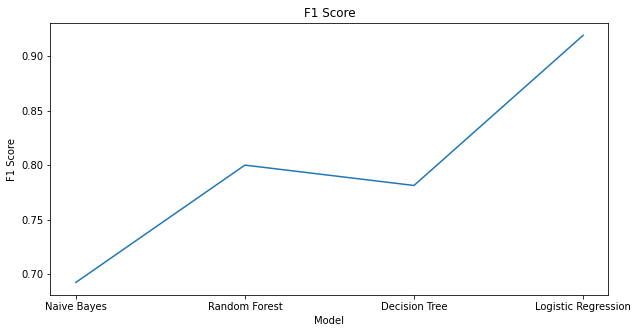

In [81]:
plot_overall_metric('F1 Score')

## Results

**1. Naive Bayes Classifier:**
- The Naive Bayes Classifier has an accuracy of 73%, weighted precision of 76%, weighted recall of 73% and weighted f1-score of 69%.
- The precision, recall and f1-score for each label is much lower in comparison with the other models.
- This model has the poorest performance in comparison to the other models.

**2. Random Forest Classifier:**
- The Random Forest Classifier has an accuracy of 81%, weighted precision of 83%, weighted recall of 76% and weighted f1-score of 78%. 
- The precision, recall and f1-score for each label is much better than the Naive Bayes model but poorer than the Logistic Regression model.
- This model is far better than the Naive Bayes model but is not as good as the Logistic Regression model.

**3. Decision Tree Classifier:**
- The Decision Tree Classifier has an accuracy of 81%, weighted precision of 83%, weighted recall of 76% and weighted f1-score of 78%. 
- The precision, recall and f1-score for each label is much better than the Naive Bayes model but poorer than the Logistic Regression model.
- This model is far better than the Naive Bayes model but is not as good as the Logistic Regression model.
- This model has the same performance metrics as the Random Forest Classifier indicating that for this use case (and dataset), the Random Forest model does not seem to have any advantage over the Decision Tree model.

**4. Logistic Regression:**
- The Logistic Regression model has an accuracy of 92%, weighted precision of 92%, weighted recall of 92% and weighted f1-score of 92%. 
- The precision, recall and f1-score for each label is much better than all the other models.
- This model is far better than all the other models.


*Note: By looking at the Precision and Recall for each model, it can be concluded that there is no overfitting as the difference between the tow metrics is not too high for any of the models.* 

## Conclusion:
It can be conluded from the classification reports of each model and the plots shown above that **Logistic Regression** model has the best performance with an accuracy of **92%**.
